In [1]:
import os
#!pip install -U numpy
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from ast import literal_eval
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import class_weight


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = pd.read_csv("spring/total.csv",encoding='utf-8')

In [4]:
data["categorias"] = data["categorias"].apply(
    lambda x: literal_eval(x)
)


In [5]:
test_split = 0.3

# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["categorias"].values,
)
# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.2)
test_df.drop(val_df.index, inplace=True)

In [6]:
terms = tf.ragged.constant(train_df["categorias"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(lookup.vocabulary_size())

Vocabulary:

32


In [7]:
flat = [item for sublist in data["categorias"].tolist() for item in sublist]
from collections import Counter
contados = Counter(flat)
{ i:contados[i] for i in vocab}

{'[UNK]': 0,
 'Artificial Intelligence': 6549,
 'Computational Intelligence': 5357,
 'Computer Science': 3988,
 'Communications Engineering, Networks': 2955,
 'Control, Robotics, Mechatronics': 2010,
 'Cyber-physical systems, IoT': 1962,
 'Professional Computing': 1538,
 'Mechanical Engineering': 1470,
 'Data Structures and Information Theory': 1189,
 'Industrial and Production Engineering': 1173,
 'Medicine & Public Health': 1171,
 'Science, Humanities and Social Sciences, multidisciplinary': 1154,
 'Machine Learning': 1079,
 'Computer Communication Networks': 1002,
 'Manufacturing, Machines, Tools, Processes': 932,
 'Robotics and Automation': 869,
 'Computer Science, general': 816,
 'Signal, Image and Speech Processing': 808,
 'Data Engineering': 795,
 'Data Mining and Knowledge Discovery': 788,
 'Control and Systems Theory': 716,
 'Business and Management': 671,
 'Aerospace Technology and Astronautics': 654,
 'Image Processing and Computer Vision': 644,
 'Computer Imaging, Vision, P

In [8]:
sample_label = train_df["categorias"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Medicine & Public Health']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [9]:
train_df["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    12643.000000
mean       112.749347
std         44.628666
min          1.000000
25%         84.000000
50%        110.000000
75%        138.000000
max        852.000000
Name: abstract, dtype: float64

In [10]:
max_seqlen = 221
batch_size = 500
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["categorias"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


In [11]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [12]:
#next(iter(train_dataset))
#train_df

text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

In [13]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print( vocabulary_size)

49811


In [14]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

def make_model():
    shallow_mlp_model = keras.Sequential(
        [

            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
            #layers.Dense( len(vocab), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model



In [15]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [

            layers.Dense(1024, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(512, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(224, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(512, activation="sigmoid"),
            layers.Dense(1024, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(512, activation="sigmoid"),
            layers.Dense(1024, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(512, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(1024, activation="sigmoid"),
            layers.Dropout(.1),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
            #layers.Dense( len(vocab), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    # Reshape((16, 8)) 
    return shallow_mlp_model

In [16]:
#shallow_mlp_model = make_model()
max_lay = 40
red = []
shallow_mlp_model =  keras.Sequential()
for i in range(max_lay):
    nodos = random.randint(800, 1024)
    red.append(nodos)
    shallow_mlp_model.add( layers.Dense(nodos, activation="sigmoid"))
    shallow_mlp_model.add( layers.Dropout(.2))
shallow_mlp_model.add( layers.Dense(1024, activation="sigmoid"))
shallow_mlp_model.add( layers.Dropout(.2))
shallow_mlp_model.add( layers.Dense(lookup.vocabulary_size(), activation="softmax"))

In [17]:
epochs = 20
#5 para acelerar las primeras versiones, solo queremos ver que no explota
#opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
opt = tf.keras.optimizers.Adamax(
    learning_rate=0.0001)
#perd = tf.keras.losses.BinaryCrossentropy( )

perd = tf.keras.losses.CategoricalCrossentropy()
# Add the class weights to the training                                         
#model.fit(x_train, y_train, epochs=10, batch_size=32, class_weight=weights)

shallow_mlp_model.compile(loss='kullback_leibler_divergence', optimizer=opt, metrics=["accuracy","binary_accuracy"])
#binary_crossentropy
#sparse_categorical_crossentropy

In [18]:
with tf.device("/GPU:0"):
    history = shallow_mlp_model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs)
#

Epoch 1/20
26/26 [==============================] - 9s 178ms/step - loss: 7.8807 - accuracy: 0.2077 - binary_accuracy: 0.9245 - val_loss: 7.3649 - val_accuracy: 0.3552 - val_binary_accuracy: 0.9256
Epoch 2/20
26/26 [==============================] - 5s 167ms/step - loss: 7.6269 - accuracy: 0.2562 - binary_accuracy: 0.9245 - val_loss: 7.3533 - val_accuracy: 0.3552 - val_binary_accuracy: 0.9256
Epoch 3/20
26/26 [==============================] - 5s 165ms/step - loss: 7.6237 - accuracy: 0.2521 - binary_accuracy: 0.9245 - val_loss: 7.3490 - val_accuracy: 0.3552 - val_binary_accuracy: 0.9256
Epoch 4/20
26/26 [==============================] - 5s 168ms/step - loss: 7.6034 - accuracy: 0.2534 - binary_accuracy: 0.9245 - val_loss: 7.3520 - val_accuracy: 0.3552 - val_binary_accuracy: 0.9256
Epoch 5/20
26/26 [==============================] - 5s 168ms/step - loss: 7.6011 - accuracy: 0.2510 - binary_accuracy: 0.9245 - val_loss: 7.3480 - val_accuracy: 0.3552 - val_binary_accuracy: 0.9256
Epoch 6/20

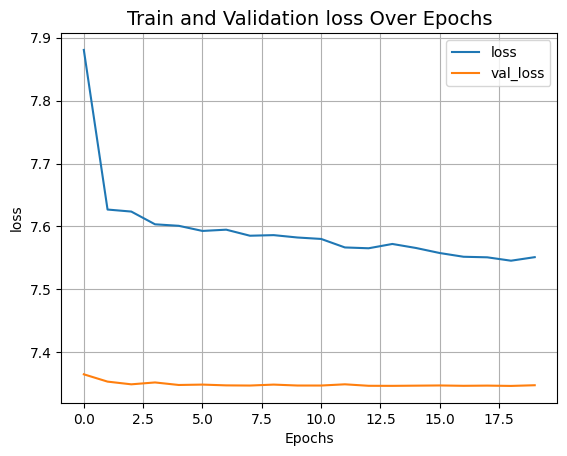

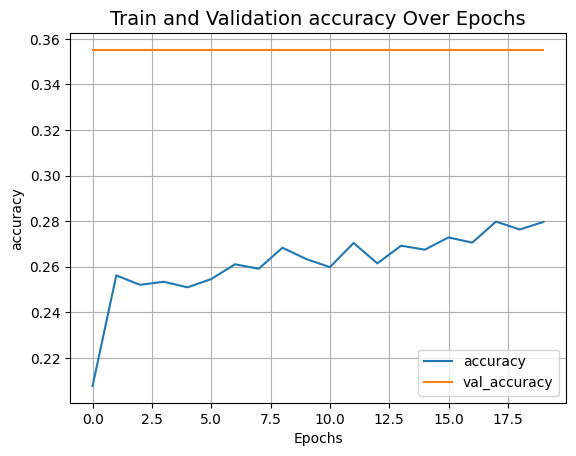

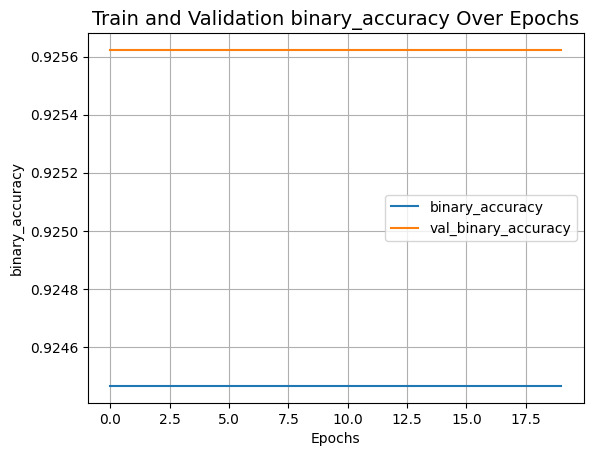

In [19]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")
plot_result("binary_accuracy")

In [20]:
#keras.models.save_model(shallow_mlp_model,'spring/radEd_model_v2.hdf5')
#shallow_mlp_model = tf.keras.models.load_model('spring/radEd_model_v2.hdf5')

In [21]:
_,accura, binary_acc  = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical binary_acc on the test set: {round(binary_acc * 100, 2)}%.")
print(f"Categorical accuracy on the test set: {round(accura * 100, 2)}%.")

9/9 [==============================] - 1s 68ms/step - loss: 7.4886 - accuracy: 0.3615 - binary_accuracy: 0.9243
Categorical binary_acc on the test set: 92.43%.
Categorical accuracy on the test set: 36.15%.


In [22]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:10]):
    label = label_batch[i].numpy()[None, ...]
    #print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Label(s): ['Transportation Technology and Traffic Engineering']
Predicted Label(s): (Artificial Intelligence, Computational Intelligence, Computer Science, Communications Engineering, Networks, Control, Robotics, Mechatronics)
 
Label(s): ['Computational Intelligence' 'Industrial and Production Engineering']
Predicted Label(s): (Artificial Intelligence, Computational Intelligence, Computer Science, Communications Engineering, Networks, Control, Robotics, Mechatronics)
 
Label(s): ['Manufacturing, Machines, Tools, Processes']
Predicted Label(s): (Artificial Intelligence, Computational Intelligence, Computer Science, Communications Engineering, Networks, Control, Robotics, Mechatronics)
 
Label(s): ['Artificial Intelligence' 'Computational Intelligence'
 'Communications Engineering, Networks' 'Control, Robotics, Mechatronics'
 'Data Structures and Information Theory']
Predicted Label(s): (Artificial Intelligence, Computational Intelligence, Computer Science, Communications Engineering, N

In [23]:

[
        x
        for  x in sorted(
            zip(predicted_probabilities[60], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:6]

[(0.14776643, 'Artificial Intelligence'),
 (0.12224217, 'Computational Intelligence'),
 (0.09322312, 'Computer Science'),
 (0.06923704, 'Communications Engineering, Networks'),
 (0.047419757, 'Control, Robotics, Mechatronics'),
 (0.04479344, 'Cyber-physical systems, IoT')]